In [1]:
from collections import Counter
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
# The list of m values and number of iterations/steps for the animations; 
# I generate graphs for larger numbers of iterations down below, but not for
# the animations (otherwise they would take a very long time to generate)
m_values, n_steps_values = [5, 15, 30], [20, 40]

MovieWriter imagemagick unavailable; using Pillow instead.


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


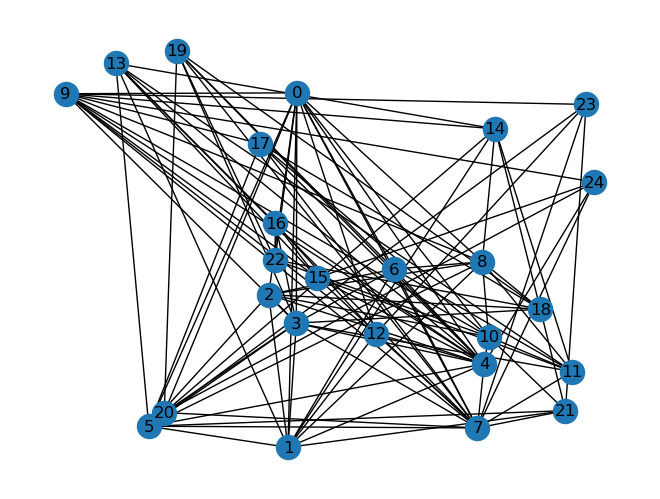

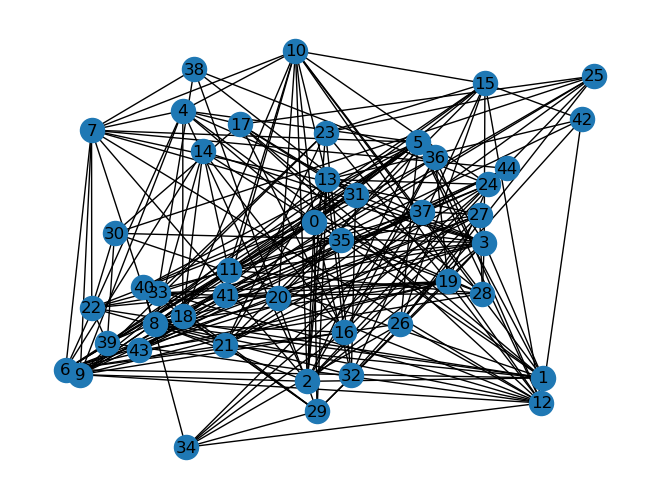

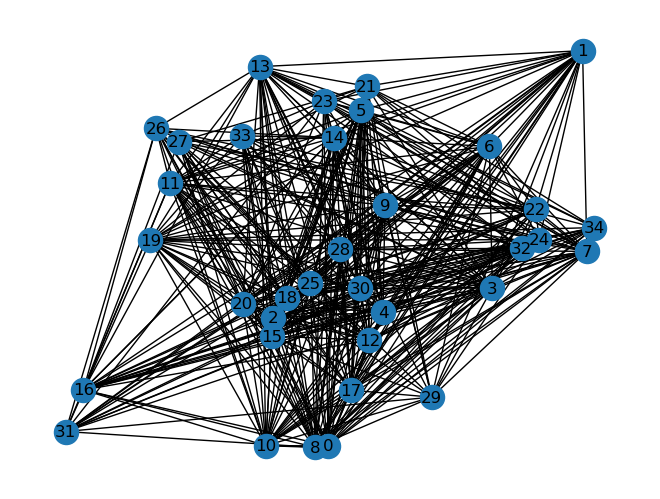

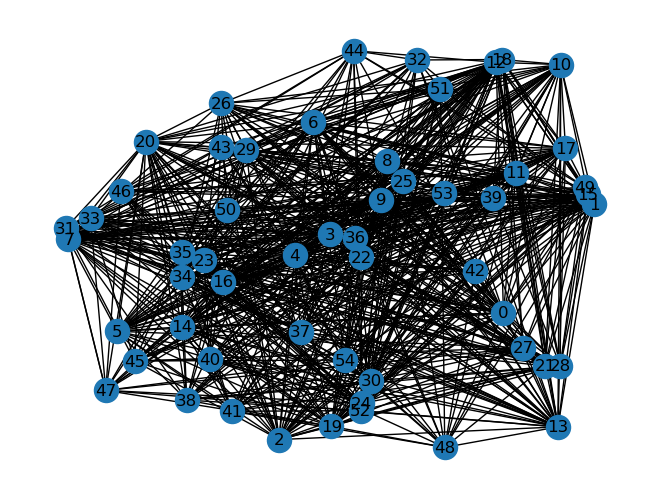

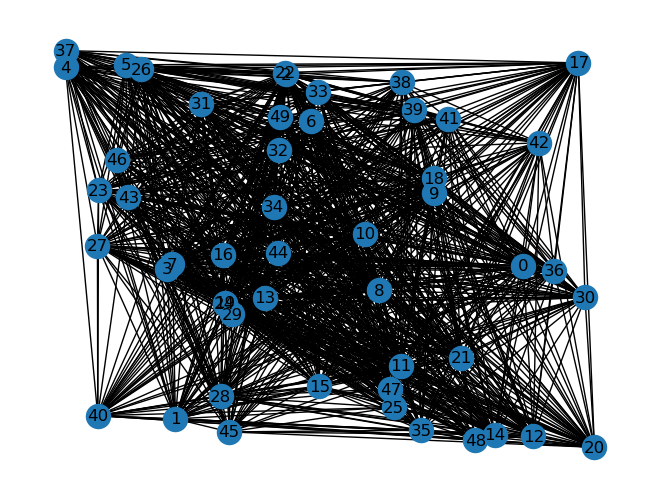

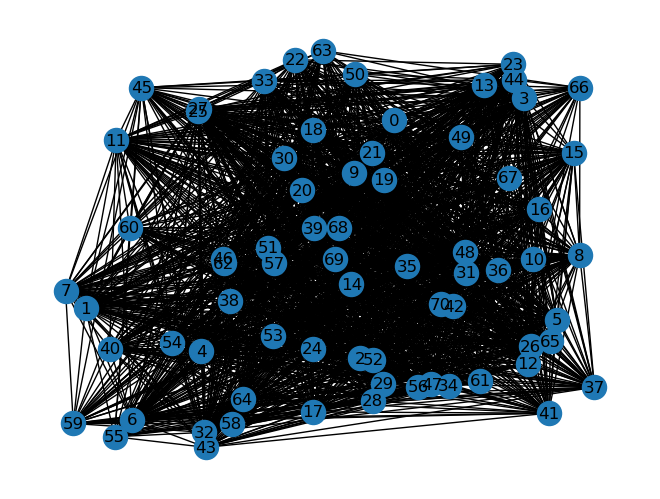

In [3]:

# Combination of my implementation of the Barabasi-Albert algorithm with code to 
# generate animations as the graphs are built
for m in m_values:
    for n_steps in n_steps_values:
        # Start with a complete graph
        G = nx.complete_graph(m)
        fig = plt.figure()
        first_frame, node_positions = True, {}

        # I try to keep the node positions the same in the animation, otherwise the network
        # plot jumps around and it's difficult to follow
        for node in G.nodes:
            node_positions[node] = (np.random.uniform(0, 1), np.random.uniform(0, 1))

        def update(frame: int) -> None:
            fig.clear()

            global first_frame
            global node_positions

            # A weird issue I found where frame 0 would occur twice
            if frame == 0 and first_frame:
                first_frame = False
                nx.draw(G, with_labels=True)
                return
            
            curr_nodes = list(G.nodes)

            # Every other frame, add a node
            if frame % 2 == 0:
                new_node = curr_nodes[-1] + 1
                G.add_node(new_node)
                node_positions[new_node] = (np.random.uniform(0, 1), np.random.uniform(0, 1))

            # Every other frame, add the edges for the new node
            else:
                new_node = curr_nodes[-1]
                curr_nodes = list(G.nodes)[:-1]
                edge_to_node_n_probabilities = [0] * len(curr_nodes)
                total_degree = 2 * G.number_of_edges()

                for node in curr_nodes:
                    node_degree = nx.degree(G, node)
                    edge_to_node_n_probabilities[node] = node_degree / total_degree

                sampled_nodes = np.random.choice(len(edge_to_node_n_probabilities), size=m, replace=False)

                for sampled_node in sampled_nodes:
                    G.add_edge(new_node, sampled_node)

            # Update the animation
            nx.draw(G, node_positions, with_labels=True)

        # Save the animation as a gif
        ani = FuncAnimation(fig, update, frames=n_steps * 2, repeat=False)
        ani.save(f'./hw3_figures/animation_{m}_{n_steps}.gif', writer='imagemagick', fps=0.5)
        

In [4]:
# The list of m values and number of iterations/steps for the animation; 
# there are larger values now because we are no longer generating animations
m_values, n_steps_values = [5, 15, 30, 50], [20, 40, 100, 1000, 10000]

# Store the graphs from my implementation and the graphs from networkx's
# implementation (for comparing the log-log plots)
my_graphs, networkx_graphs, parameter_tuples = [], [], []

In [5]:
# Generate graphs using my implementation (similar to the animation code above)
for m in m_values:
    for n_steps in n_steps_values:
        G = nx.complete_graph(m)

        for _ in range(n_steps):
            curr_nodes = list(G.nodes)
            new_node = curr_nodes[-1] + 1
            edge_to_node_n_probabilities = [0] * len(curr_nodes)
            total_degree = 2 * G.number_of_edges()

            for node in curr_nodes:
                node_degree = nx.degree(G, node)
                edge_to_node_n_probabilities[node] = node_degree / total_degree

            sampled_nodes = np.random.choice(len(edge_to_node_n_probabilities), size=m, replace=False)

            for sampled_node in sampled_nodes:
                G.add_edge(new_node, sampled_node)

        my_graphs.append(G)
        parameter_tuples.append((m, n_steps))

In [6]:
# Generate graphs using networkx's implementation
for m in m_values:
    for n_steps in n_steps_values:
        G = nx.barabasi_albert_graph(m + n_steps, m, initial_graph=nx.complete_graph(m))
        networkx_graphs.append(G)

In [7]:
# Safety check
assert len(my_graphs) == len(networkx_graphs)

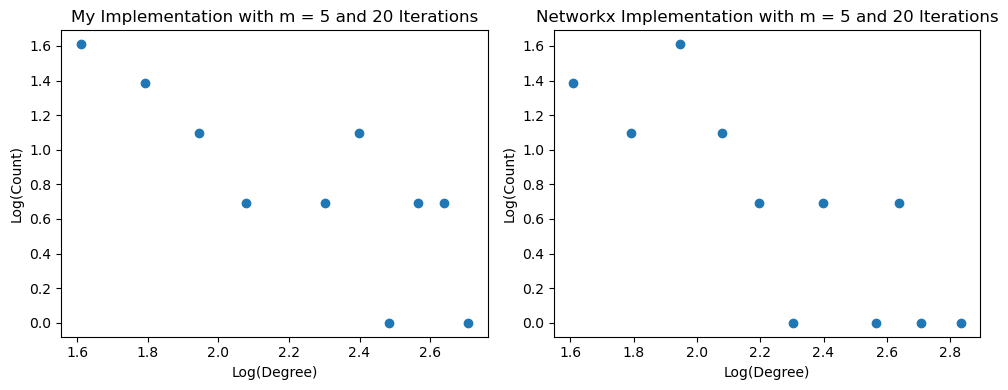

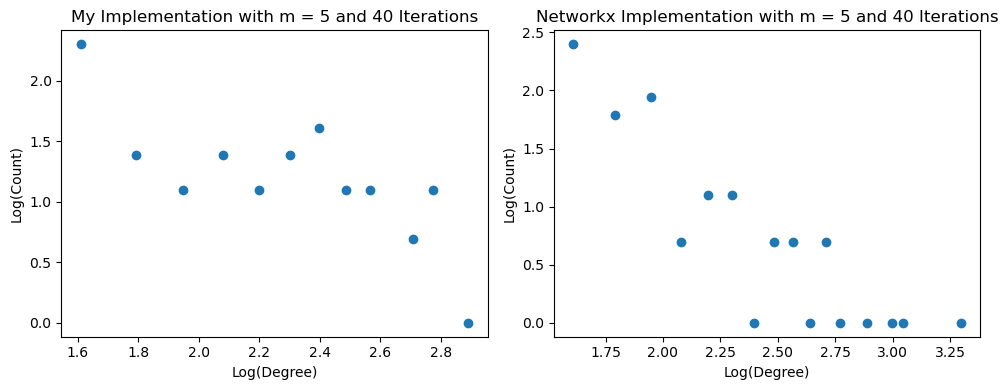

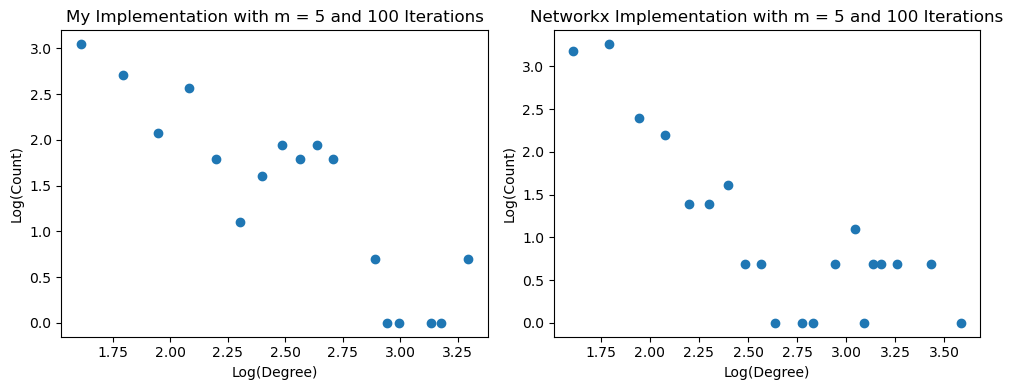

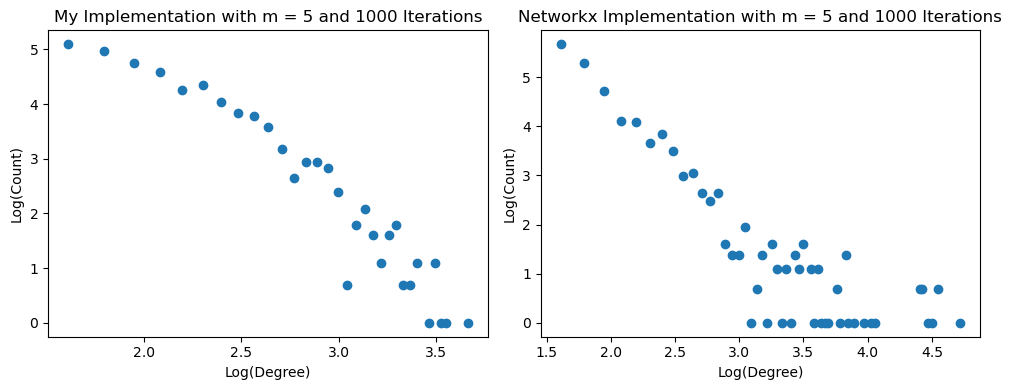

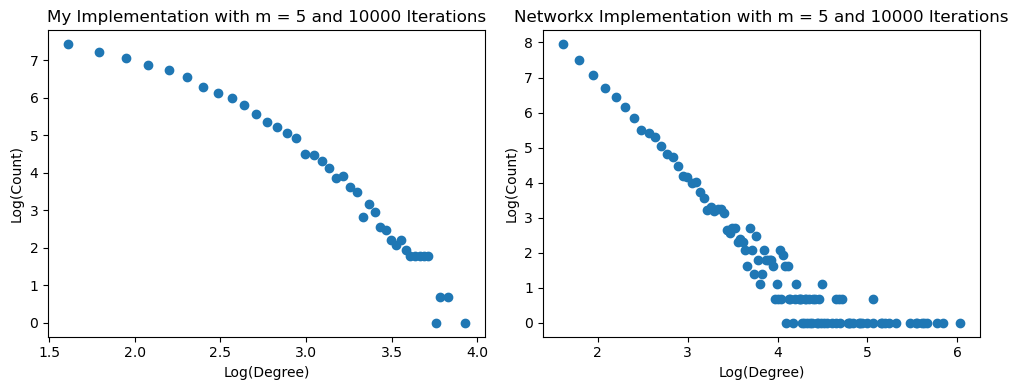

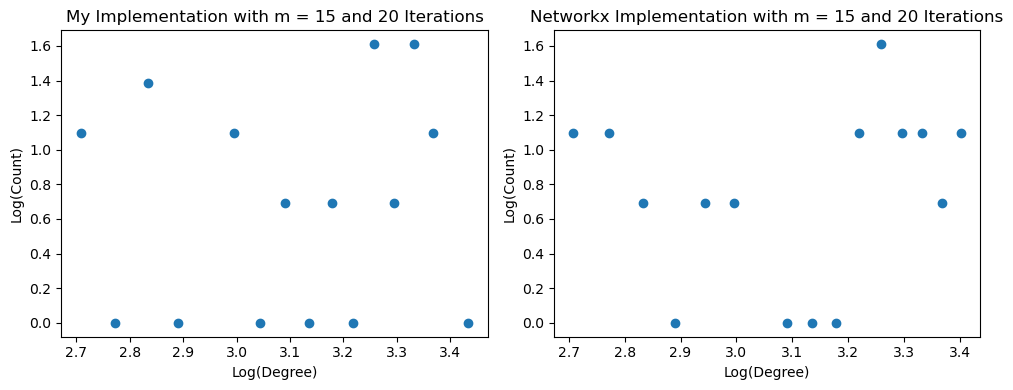

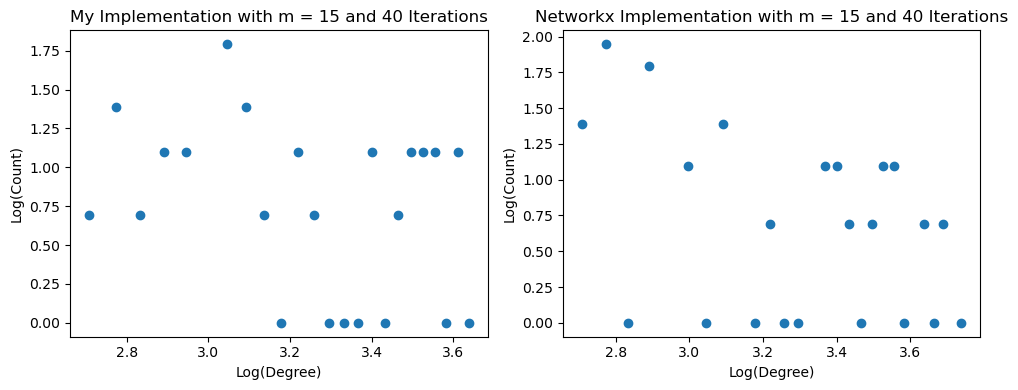

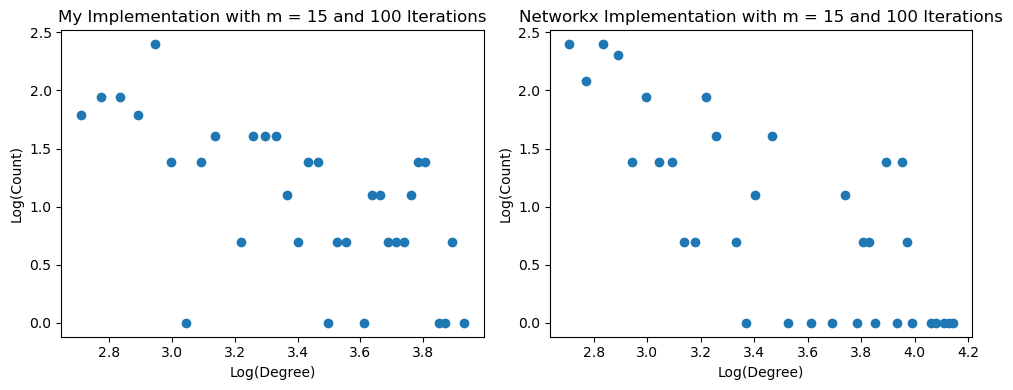

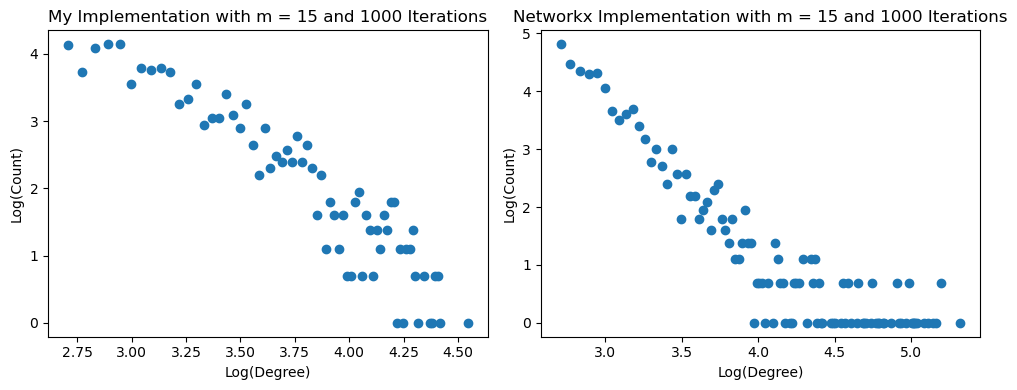

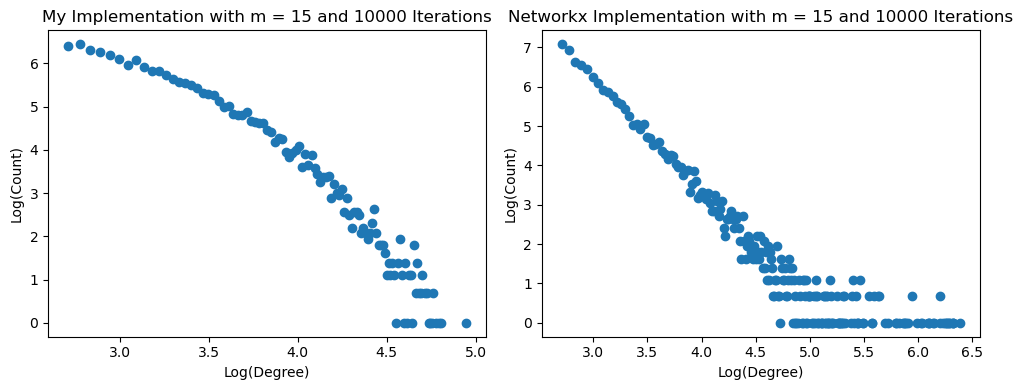

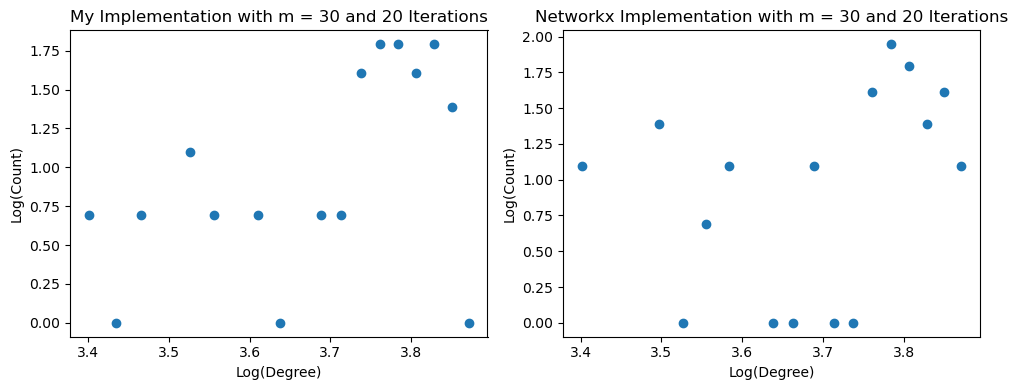

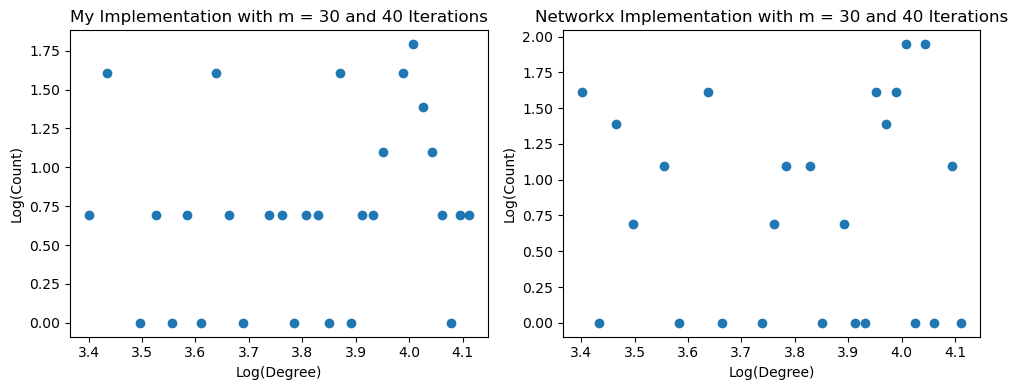

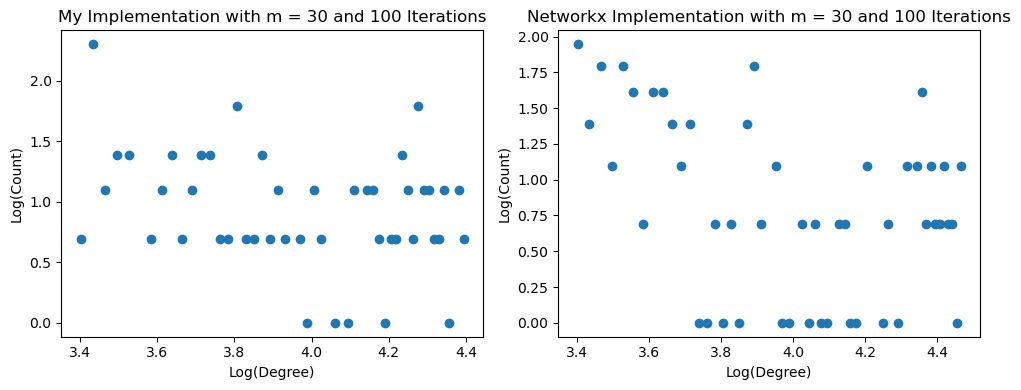

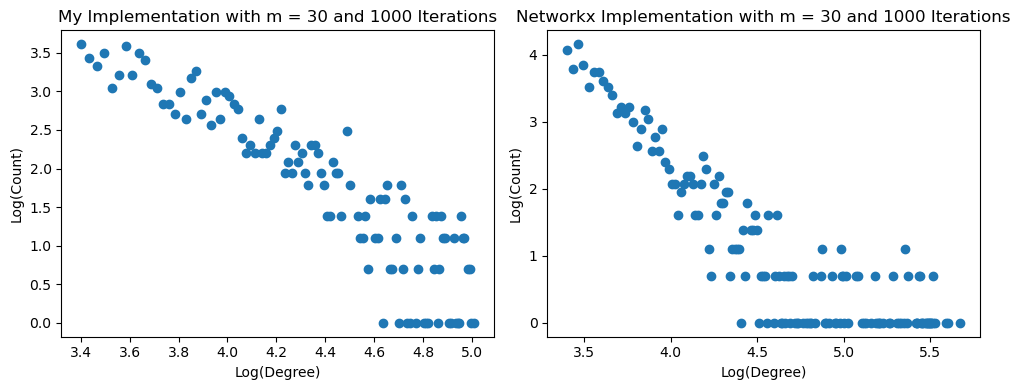

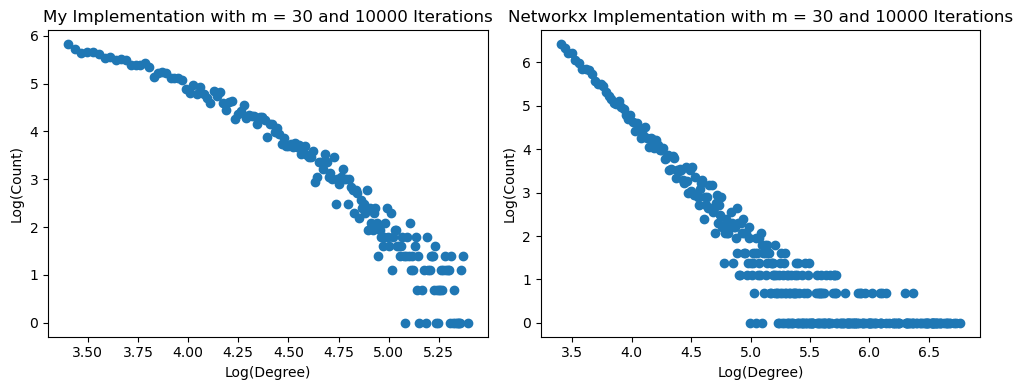

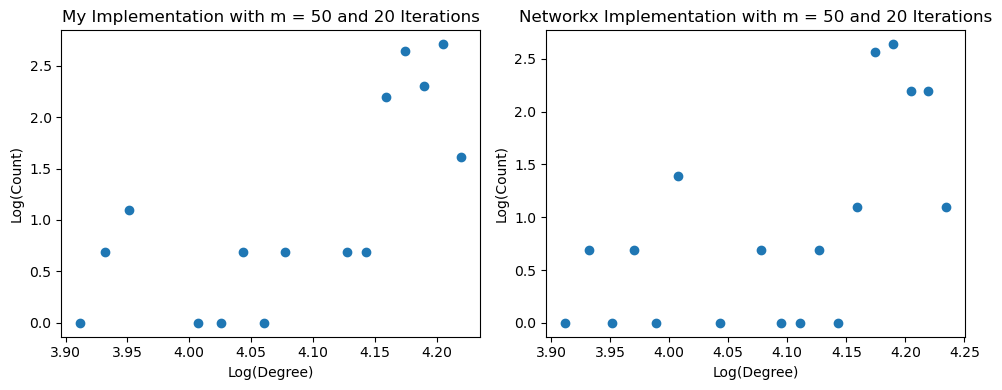

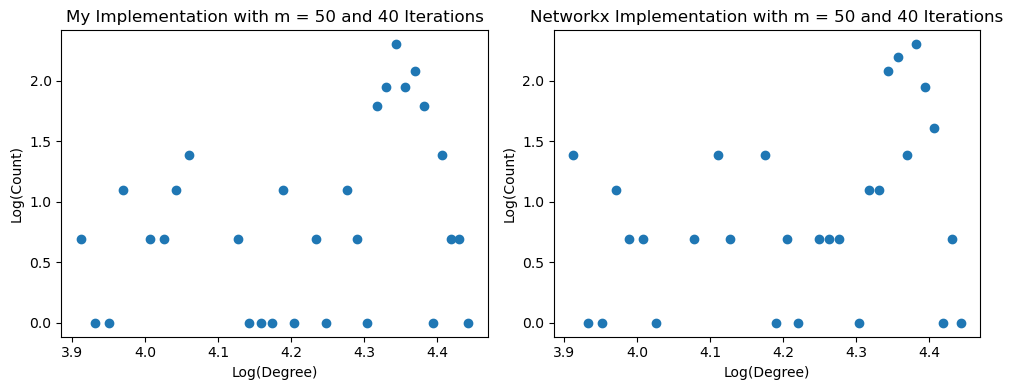

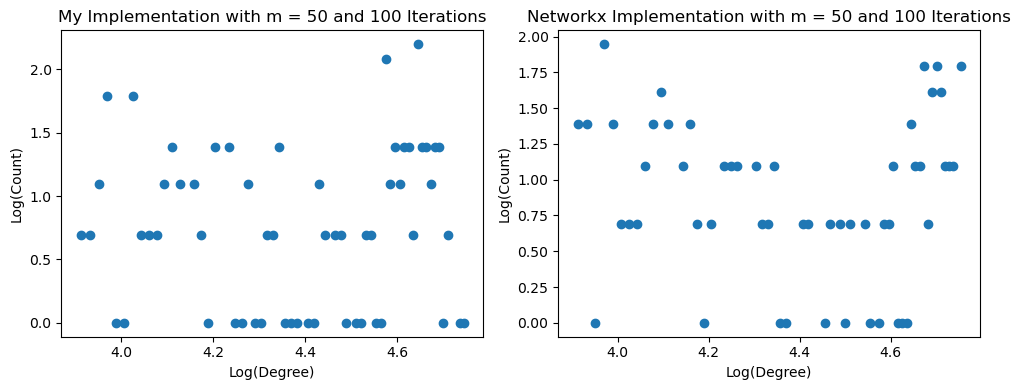

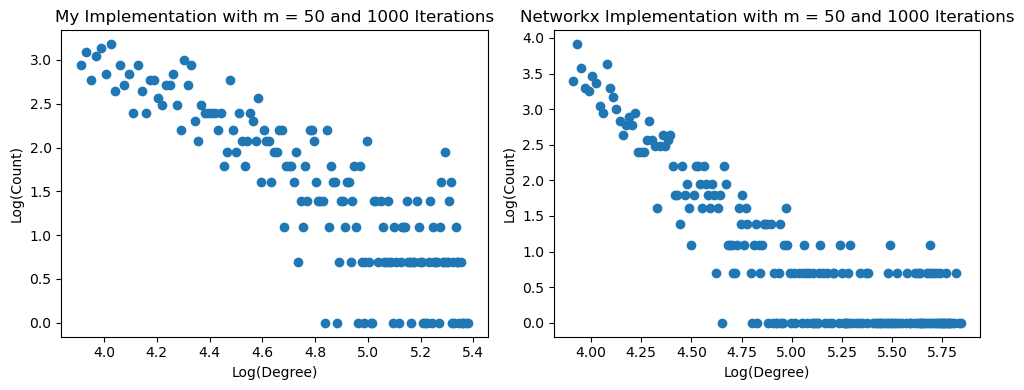

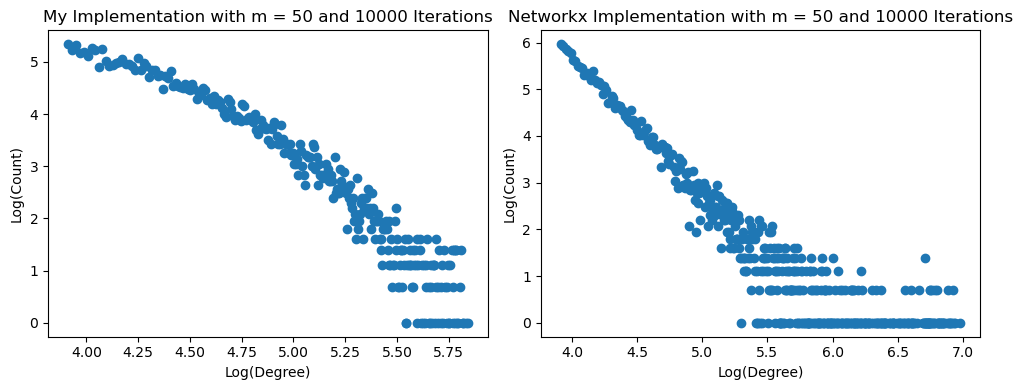

In [8]:
# Create side-by-side log-log plots of the degree distributions, one for 
# my implemnation and one for network's implementation
for i in range(len(my_graphs)):
    my_graph, networkx_graph = my_graphs[i], networkx_graphs[i]
    m, n_steps = parameter_tuples[i]

    degrees = dict(my_graph.degree()).values()
    degree_counts = Counter(degrees)

    degrees_networkx = dict(networkx_graph.degree()).values()
    degree_counts_networkx = Counter(degrees_networkx)

    degree_values_scaled, degree_counts_scaled = np.log(list(degree_counts.keys())), np.log(list(degree_counts.values()))
    degree_values_networkx_scaled, degree_counts_networkx_scaled = np.log(list(degree_counts_networkx.keys())), np.log(list(degree_counts_networkx.values()))

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].scatter(degree_values_scaled, degree_counts_scaled, marker='o')
    axs[0].set_title(f'My Implementation with m = {m} and {n_steps} Iterations')
    axs[0].set_xlabel('Log(Degree)')
    axs[0].set_ylabel('Log(Count)')

    axs[1].scatter(degree_values_networkx_scaled, degree_counts_networkx_scaled, marker='o')
    axs[1].set_title(f'Networkx Implementation with m = {m} and {n_steps} Iterations')
    axs[1].set_xlabel('Log(Degree)')
    axs[1].set_ylabel('Log(Count)')

    plt.tight_layout()
    plt.show()

### Summary

<ul>
    <li>  See the plots above.  The networks that were built with a larger number of iterations (a large number of nodes) appear to be scale-free (their log-log degree distributions appear to be roughly linear).  For networks with fewer nodes, it is more difficult to tell.
    <li> For the most part, the log-log plots look linear for both my implementation and networkx's implementation (which is a good sign that I implemented the algorithm correctly).  However, the plots tend to break from a "straight line" as the log(degree) values grow larger.  This is something we discussed in class, and is probably due to the fact that there is less data for nodes with extremely large degrees.
    <li> Based on the log-log plots, it looks like my implementation is similar to networkx's.  However, their version seems to run faster than mine.  I imagine they use optimization techniques, whereas I just "brute forced" my implementation.
    <li> From the animations and our discussion in class, nodes with larger degrees tend to gain more edges over time.  As they gain more edges, they are even more likely to gain additional edges in the future.  This can be viewed as "the rich get richer" effect.  The rich typically have more wealth and opportunities to further grow their wealth.  As their wealth grows, their ability to make even more money grows as well.  In network terms, there is "preferential attachment", where new nodes are more likely to attach to nodes with larger degrees.  Since the network grows over time and there is preferential attachment, the network is scale free.
</ul>